## Problem 1
### Milad Heidari
### Student Number: 98101469

In [1]:
import torch
import math
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Lambda
from torchvision.transforms import ToTensor
from torchvision.datasets import FashionMNIST

In [2]:
# set device to cuda if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### A)

In [3]:
DATA_PATH = 'data/'
NUM_CLASSES = 10

def label_map(label):
    label_one_hot = torch.zeros((NUM_CLASSES,))
    label_one_hot[label] = 1
    return label_one_hot


train_set = FashionMNIST(
    root=DATA_PATH,
    train=True,
    download=False,
    transform=ToTensor(),
    target_transform=label_map
)

test_set = FashionMNIST(
    root=DATA_PATH,
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=label_map
)

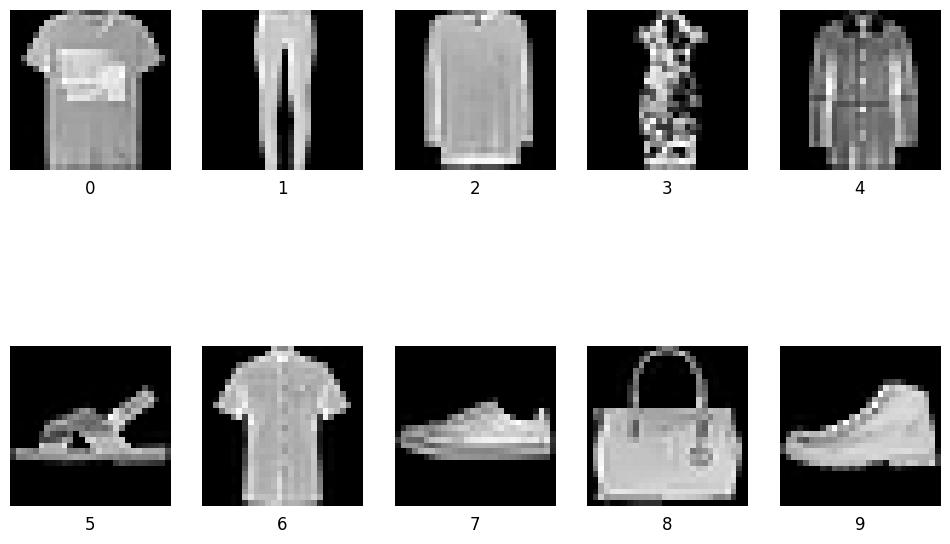

In [4]:
fig = plt.figure(figsize=(12, 8))
for i in range(0, 10):
    sample_dataloader = DataLoader(train_set, shuffle=True)
    for image, label in sample_dataloader:
        if label.argmax().item() == i:
            ax = fig.add_subplot(2, 5, i+1)
            ax.set_axis_off()
            ax.imshow(image.cpu().squeeze().reshape((28, 28)), cmap='gray')
            ax.set_title(i, y=-0.2, size=12)
            break

#### B)

In [5]:
class MyLinear:
    def __init__(self, input_dim, output_dim, device='cpu'):
        mult_factor = np.sqrt(4 / (input_dim + output_dim))
        self.W = torch.randn((output_dim, input_dim), requires_grad=True) # * mult_factor
        self.b = torch.randn((1, output_dim), requires_grad=True) # * mult_factor
        self.W = self.W.to(device)
        self.b = self.b.to(device)
        self.W.retain_grad()
        self.b.retain_grad()
    
    def __call__(self, X):
        result =  X @ self.W.T + self.b
        return result
    
    
    def parameters(self):
        return [self.W, self.b]


class MySigmoid:
    
    def __call__(self, X):
        result = 1 / (1 + torch.exp(-X))
        return result
            
    
    def parameters(self):
        return []
    

class MyReLU:
    
    def __call__(self, X):
        result = torch.max(torch.zeros(X.shape).to(device), X)
        return result
    
    def parameters(self):
        return []
    
    
class MySoftMax():
    
    def __call__(self, X):
        X = torch.exp(X)
        X = X / torch.sum(X, dim=1).reshape(-1, 1)
        return X
    
    
    def parameters(self):
        return []

    
class MyFlatten():
    
    def __call__(self, X):
        result = X.squeeze().reshape(X.shape[0], -1)
        return result
    
    def parameters(self):
        return []
    
    
class MySequential:
    
    def __init__(self, *layers):
        self.layers = layers
        
    
    def __call__(self, X):
        for layer in self.layers:
            X = layer(X)
            
        return X
    
    
    def parameters(self):
        params = []
        
        for layer in self.layers:
            params += layer.parameters()
            
        return params


class MyCrossEntropyLoss:
    
    current_loss = 0
    
    def __call__(self, y, y_pred):
        loss = (-y * torch.log(y_pred)).sum() / y.shape[0]
        current_loss = loss
        current_loss.retain_grad
        loss.retain_grad
        return loss
    
    def backward(self):
        return current_loss.backward()
    

class MySGD:
    
    def __init__(self, parameters, lr=1e-4):
        self.parameters = parameters
        self.lr = lr
        
    def step(self):
        for params in self.parameters:
            params -= self.lr*params.grad
            
    
    def zero_grad(self):
        for params in self.parameters:
            params.grad = None
            
class MyBatchNorm1D:
    
    def __init__(self, input_dim):
        self.input_dim = input_dim
        
        
    def __call__(self, X):
        mu = X.mean(dim=0).reshape(1, -1)
        sigma = X.std(dim=0).reshape(1, -1).detach().clone()
        sigma[sigma == 0] = 1
        result = (X - mu)/sigma
        return result
    
    def parameters(self):
        return []

In [6]:
class MyNeuralNetwork:
    
    def __init__(self, device='cpu'):
    
        self.flatten = MyFlatten()
        self.linear_relu_stack = MySequential(
            MyLinear(784, 1024, device=device),
            MyReLU(),
            MyBatchNorm1D(1024),
            MyLinear(1024, 512, device=device),
            MyReLU(),
            MyBatchNorm1D(512),
            MyLinear(512, 256, device=device),
            MyReLU(),
            MyBatchNorm1D(256),
            MyLinear(256, 64, device=device),
            MyReLU(),
            MyBatchNorm1D(64),
            MyLinear(64, 10, device=device),
            MySigmoid()
        )
        self.softmax = MySoftMax()
    
    
    def forward(self, X):
        X = self.flatten(X)
        X = self.linear_relu_stack(X)
        X = self.softmax(X)
        return X
    

    def __call__(self, X):
        return self.forward(X)
    
    
    def parameters(self):
        params = []
        for layer in self.__dict__.values():
            params += layer.parameters()
        
        return params

#### C)

In [7]:
# create an instance of the model defined above
model = MyNeuralNetwork(device='cuda')

In [8]:
# setting hyperparameters
learning_rate = 10
batch_size = 128
epochs = 25

In [9]:
# initialize the cost function and choose an optimizer
loss_fn = MyCrossEntropyLoss()
optimizer = MySGD(model.parameters(), lr=learning_rate)

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer, train_losses=None, save_losses=False):
    size = len(dataloader.dataset)
    num_correct = 0
    for batch_num, (X, y) in enumerate(dataloader):
        # forward prop
        X = X.to(torch.float32).to(device)
        y = y.to(device)
        y_pred = model(X)
        loss = loss_fn(y, y_pred)
        num_correct += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
        # back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if save_losses:
            if batch_num % 100 == 0:
                train_losses.append(loss.item())
        
    accuracy = num_correct / size
    print(f'train_loss: {loss.item()}')
    print(f'Train Accuracy: {np.round(accuracy*100, 2)}%')
    
            
def test_loop(dataloader, model, loss_fn, test_losses=None, save_losses=False):
    size = len(dataloader.dataset)
    num_correct = 0
    with torch.no_grad():
        for batch_num, (X, y) in enumerate(dataloader):
            X = X.to(torch.float32).to(device)
            y = y.to(device)
            y_pred = model(X)
            loss = loss_fn(y, y_pred)
            num_correct += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
            
            if save_losses:
                if batch_num % 100 == 0:
                    test_losses.append(loss.item())
        
                        
    accuracy = num_correct / size
    print(f'Test Accuracy: {np.round(accuracy*100, 2)}%')

In [11]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
train_losses = []
test_losses = []

for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_loop(train_dataloader, model, loss_fn, optimizer, train_losses=train_losses, save_losses=True)
    test_loop(test_dataloader, model, loss_fn, test_losses=test_losses, save_losses=True)
    print()

epoch 1 ==================================================
train_loss: 1.62835693359375
Train Accuracy: 68.47%
Test Accuracy: 73.57%

epoch 2 ==================================================
train_loss: 1.5970739126205444
Train Accuracy: 75.23%
Test Accuracy: 75.09%

epoch 3 ==================================================
train_loss: 1.637969732284546
Train Accuracy: 77.51%
Test Accuracy: 77.45%

epoch 4 ==================================================
train_loss: 1.5847477912902832
Train Accuracy: 80.26%
Test Accuracy: 80.22%

epoch 5 ==================================================
train_loss: 1.5378206968307495
Train Accuracy: 83.63%
Test Accuracy: 83.11%

epoch 6 ==================================================
train_loss: 1.546405553817749
Train Accuracy: 85.54%
Test Accuracy: 83.99%

epoch 7 ==================================================
train_loss: 1.5438731908798218
Train Accuracy: 86.18%
Test Accuracy: 84.37%

epoch 8 ============================================

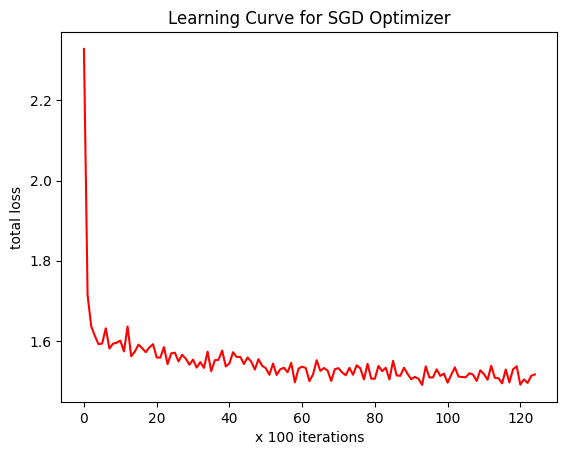

In [15]:
plt.plot(train_losses, color='red')
plt.xlabel('x 100 iterations')
plt.title('Learning Curve for SGD Optimizer')
plt.ylabel('total loss');

In [ ]:
torch.save(model, 'trained_model_p1.pt')

#### D)

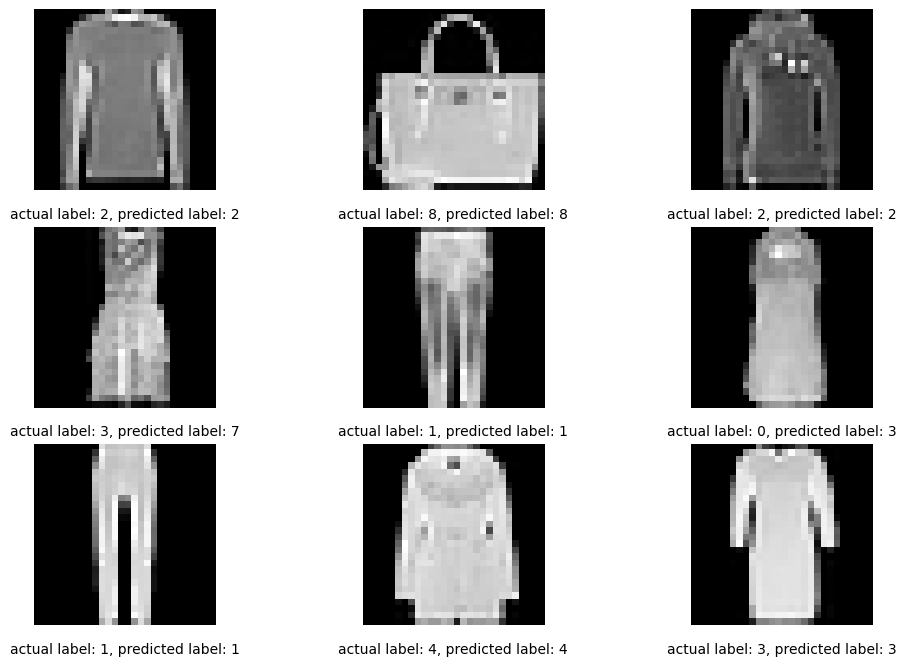

In [45]:
test_dataloader = DataLoader(test_set, batch_size=9, shuffle=True)
X, y = next(iter(test_dataloader))
X, y = X.to(device), y.to(device)
y_pred = model(X)

fig = plt.figure(figsize=(12, 8))
for i in range(0, 9):
    image = X[i, :].squeeze()
    actual_y = y[i, :].argmax().item()
    predicted_y = y_pred[i, :].argmax().item()
    ax = fig.add_subplot(3, 3, i+1)
    ax.set_axis_off()
    ax.imshow(image.cpu(), cmap='gray')
    ax.set_title(f'actual label: {actual_y}, predicted label: {predicted_y}', y=-0.2, size=10)
    